<a href="https://colab.research.google.com/github/rezu98/colab/blob/main/mae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
## from pmdarima.arima import auto_arima


In [2]:
pwd

'/content'

In [3]:
# Upload the Excel file into a Pandas dataframe
df = pd.read_excel('tri.xlsx')

In [4]:
# adjustion
df['date'] = pd.to_datetime(df['date']) # date definition

In [5]:
# Fit the quadratic trend model to the 'index' series
df['time'] = np.arange(len(df))
df['time_sq'] = df['time'] ** 2
df['constant'] = 1

In [ ]:
model = sm.OLS(df['index'], df[['constant', 'time', 'time_sq']])
results = model.fit(cov_type='HAC', cov_kwds={'maxlags': 1})
print(results.summary())

# Extract the fitted series
df['fitted_values'] = results.fittedvalues

In [9]:
# Apply the HP filter to the 'index' series without considering the quadratic trend
cycle, trend = sm.tsa.filters.hpfilter(df['index'], lamb=1600)

# Add the HP-filtered trend back to the DataFrame
df['hp_trend'] = trend

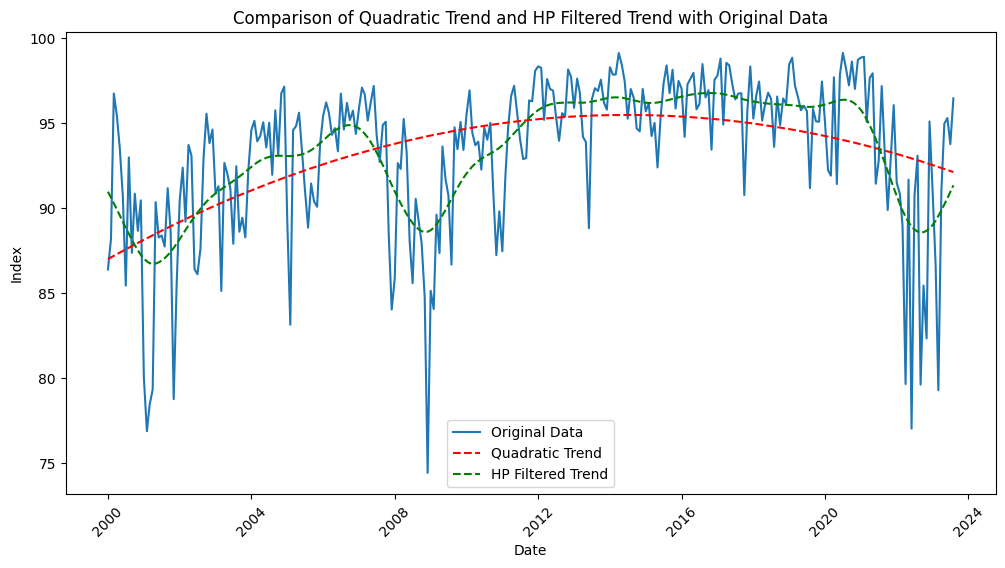

In [15]:
# Plot the original data, the quadratic trend, and the HP-filtered trend
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['index'], label='Original Data')
plt.plot(df['date'], df['fitted_values'], label='Quadratic Trend', linestyle='--', color='r')
plt.plot(df['date'], df['hp_trend'], label='HP Filtered Trend', linestyle='--', color='g')
plt.legend()

# Set the X-axis with the 'date' column
plt.xlabel('Date')
plt.ylabel('Index')
plt.title('Comparison of Quadratic Trend and HP Filtered Trend with Original Data')
plt.xticks(rotation=45)

# Display the plot
plt.show()

이전과 이후 구분

In [6]:
# Print the first few rows of the dataframe
# print(df.head())  # five row display
df.columns  # column index
df.info()
# df.shape  # matrix size

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284 entries, 0 to 283
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    284 non-null    datetime64[ns]
 1   index   284 non-null    float64       
 2   dum_f   284 non-null    int64         
 3   dum_c   284 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 9.0 KB


In [ ]:
# SImple OLS

X = df[['mee','cha', 'mper']]

# Define a list of dependent variables
dependent_vars = ['absc_call', 'absc_cd', 'absc_b_3m', 'absc_b_1y', 'absc_b_3y', 'absc_b_5y', 'absc_b_10y']

# Create an empty list to store the results of each OLS regression
results = []

# Loop through the dependent variables and fit the OLS model with each variable
for var in dependent_vars:
    y = df[var]
    X = sm.add_constant(X)
    model =  sm.OLS(y, X).fit(cov_type='HC3')
    results.append(model)

    # Print the results of each OLS regression
    print(f"Model {len(results)}: {var} as dependent variable\n{model.summary()}")

# Plot the residual graph for the current model
    plt.plot(model.resid)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.title(f"Residual plot for {var}")
    plt.xlabel("Observation")
    plt.ylabel("Residual")
    plt.show()

# 1. 종속변수와 독립변수간 선형관계 - 당연히 만족
# 2. 독립변수와 오차항간 상관관계가 없을 것 - 독립변수 설정 잘하면 문제 없음
# 3. 오차항의 기대값은 0 - 랜덤웍
# 4. 오차항은 정규분포 - 모집단 많으면 해결

# 5. 오차항의 분산이 모든 관찰치에서 일정한 상수일 것, 아닐 경우 이분산성(Heteroskedasticity) 발생
## 무조건부 이분산성은 독립변수 관찰값과 상관없는 이분산, 조건부(Conditional Variance) 이분산은 독립변수 관찰값과 상관있는 이분산, 조건부 이분산은 GARCH 사용
## Breusch-Pagan Test로 검정
## H0 = 이분산성 비존재, P value < 0.05시 기각가능해서 이분산 존재
## HAC (Newey-West Standard error, HAC Heteroskedasticity and Autocorrelation Consistent) standard errors로 수정가능, 이 경우 robust standard error

    # Breusch-Pagan test for heteroscedasticity
    bp_test = het_breuschpagan(model.resid, X)
    print(f"Breusch-Pagan test statistic: {bp_test[0]:.3f}")
    print(f"Breusch-Pagan p-value: {bp_test[1]:.3f}")
    if bp_test[1] < 0.05:
        print("Warning: The residuals exhibit heteroscedasticity.")

# 6. 오차항간 시차상관관계가 없을 것, 아닐 경우 계열상관성(Autoregression) 발생
## HAC (Newey-West Standard error, HAC Heteroskedasticity and Autocorrelation Consistent) standard errors로 수정가능, 이 경우 robust standard error
## Calculate Durbin-Watson statistic
## Durbin-Watson statistic for autocorrelation
    dw = durbin_watson(model.resid)
    print(f"Durbin-Watson statistic: {dw:.3f}")
## check for autocorrelation

    if dw < 1.5 or dw > 2.5:
        print("Warning: The residuals exhibit autocorrelation.")


 # Jarque-Bera test for normality of residuals
    jb_test = jarque_bera(model.resid)
    test_statistic = jb_test[0]
    p_value = jb_test[1]
    if p_value < 0.05:
        print("Warning: The residuals are not normally distributed (p-value = {:.4f})".format(p_value))
    else:
        print("The residuals are normally distributed (p-value = {:.4f})".format(p_value))

    # ADF test for stationarity of residuals
    residuals = model.resid
    adf_test = sm.tsa.stattools.adfuller(residuals)
    test_statistic = adf_test[0]
    p_value = adf_test[1]
    if p_value < 0.05:
        print("Warning: The residuals have a unit root (p-value = {:.4f})".format(p_value))
    else:
        print("The residuals do not have a unit root (p-value = {:.4f})".format(p_value))

In [ ]:
# 7. 독립변수간 상관관계가 없을 것, 아닐 경우 다중공선성(Multicollinearity) 발생
## calculate the VIF for each independent variable
vif = pd.DataFrame()
independent_vars=['mee2','cha','mper']   # only pass the column names
vif["variables"] = independent_vars
vif["VIF"] = [variance_inflation_factor(df[independent_vars].values, i) for i in range(len(independent_vars))]

### check for high VIFs (typically a VIF greater than 5 or 10 is considered high)
high_vif = vif[vif['VIF'] > 5]

# print the variables with high VIFs
if len(high_vif) > 0:
    print("Warning: The following variables have high VIFs:")
    print(high_vif)

    # if there are high VIFs, drop one of the variables with the highest VIF
    var_to_drop = high_vif.sort_values('VIF', ascending=False)['variables'].iloc[0]
    df.drop(var_to_drop, axis=1, inplace=True)
    independent_vars.remove(var_to_drop)
else:
    print("No variable has a high VIF.")

In [ ]:
# 금융데이터처럼 변동성이 시간에 따라 변화(clustering) = 시계열 데이터의 조건부 분산이 과거 시점의 오차항과 자기상관
# 시변하는 조건부 분산을 GARCH로 예측
## 실제 value와 fit value로 arch가 잘 맞는지 보고
## redisual이 정규분포하는지 보고
## conditional variance가 시변하는지 봄
### 이후 conditional variance그래프를 그리고 주요 뉴스 전후로 어떻게 바뀌는지 확인

# 참고
## AR(1)은 t기의 오차항이 t-1기의 오차항과 관련
## ARCH는 t기의 오차항의 분산이 t-1기의 오차항 분산과 관련
### 오차항의 분산이 전기 오차항의 제곱에 관련 있는 경우를 autoregressive conditional heteroscedasticity(ARCH)
### 오차항의 분산이 여러 기의 오차항 제곱과 관련 있는 경우 generalized ARCH(GARCH)
### 금융모형 다수 등장

In GARCH (Generalized Autoregressive Conditional Heteroscedasticity) models, the parameters (p,q) represent the orders of the autoregressive and moving average terms, respectively, that are used to model the conditional variance of a time series.

The "p" parameter specifies the order of the autoregressive term, which models the dependence of the current variance on the past variances. The "q" parameter specifies the order of the moving average term, which models the dependence of the current variance on the past squared error terms.

Together, the (p,q) parameters determine the complexity of the GARCH model and how well it can capture the volatility patterns in the data. In practice, these parameters are usually chosen through a process of model selection, such as using information criteria like the Akaike Information Criterion (AIC) or the Bayesian Information Criterion (BIC), or through cross-validation techniques.

delta(y_t) = beta_0 + beta_1*y_(t-1)(=AR1)+e_t(=error term) ~ e_t=beta_2(square(hat^2_t))   ~ N(0, hat_t)
hat^2_t = Omega + sigma(alpha*h_(t-p)(=AR term, p)) + (Beta*e_(t-q))(MA term, q)

AR(1) 과정에서 오차항의 분산이 이분산성(시변성), 클러스터링 분산을 보일 경우
오차항의 시변하는 분산 hat^2을 ARIMA 과정을 통해 별도로 추정
이 때 Omega는 시변성이 없었을 경우 나타날 Constant mean, alpha는 AR Term의 계수
Beta는 MA Term의 계수로 과거 에러텀 제곱의 영향

In [ ]:
# Define ranges of p and q to search over
p_range = range(1, 3)
q_range = range(1, 3)

# Initialize the best model and criterion values
best_aic = np.inf
best_bic = np.inf
best_p = 0
best_q = 0

# Loop through all combinations of p and q values
for p in p_range:
    for q in q_range:
        # Fit a GARCH model for each combination of p and q
        model = arch_model(df['b_3y_l'], vol='GARCH', p=p, q=q, mean='constant', dist='Normal')
        result = model.fit(disp='off')

        # Calculate the AIC and BIC for each model
        aic = result.aic
        bic = result.bic

        # Check if the current model has a lower AIC or BIC than the previous best model
        if aic < best_aic:
            best_aic = aic
            best_p = p
            best_q = q

        if bic < best_bic:
            best_bic = bic
            best_p = p
            best_q = q

# Print the optimal (p, q) values and criterion values
print("Optimal (p, q) values based on AIC: ({}, {})".format(best_p, best_q))
print("AIC value for optimal model: {}".format(best_aic))

print("Optimal (p, q) values based on BIC: ({}, {})".format(best_p, best_q))
print("BIC value for optimal model: {}".format(best_bic))

In [ ]:
# Fit the GARCH(p,q) model

# Define the independent variables
y = df['b_3y_l']

# Fit the GARCH(1,1) model
am = arch_model(y, mean="AR", vol="GARCH", p=1, q=1, dist='Normal')     ## Clear Trend가 있을 경우 mean = AR, 아닐 경우 Conditional mean이 Constant하다고 하는 것이 보통
results = am.fit()

# Print model summary
print(results.summary())

## log-likelihood value = -6476.46 = fit well
## coefficients of vol is fit well
### omega coefficient = the constant component of the variance = 0.0253 > i.e., long-run average의 존재
### alpha1 = conditional variance lagged one period > 0.1 > short past squard residuals affect currentvolitaility, AR(1) term
### beta1 = conditional variance itself > 0.8000 > long past squared residuals affect current volitaility, MA(1) term
## beta1 < 1 and alpha+beta < 1 (1,1)
## i.e., the tendency for periods of high volatility to follow periods of high volatility and for periods of low volatility to follow periods of low volatility.

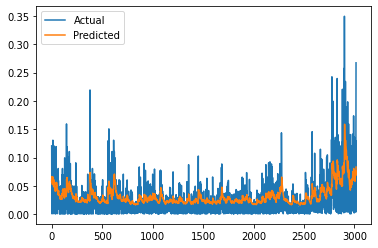

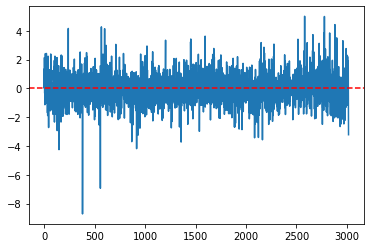

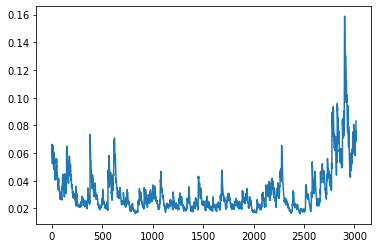

In [ ]:
# Plotting the actual and predicted values of the dependent variable:
## means how well the model fits the actual data. closely = fit
predicted = results.conditional_volatility
actual = np.sqrt(results.resid**2)

plt.plot(actual, label='Actual')
plt.plot(predicted, label='Predicted')
plt.legend()
plt.show()

# Plotting the standardized residuals:
## standardized residuals, normally distributed around zero = fit

from statsmodels.graphics.tsaplots import plot_acf

std_resid = results.resid / results.conditional_volatility
# (obs - actu / con var) = like z-score.
# rule of thumb = between +-2 = ok

plt.plot(std_resid)
plt.axhline(y=0, color='red', linestyle='--')
plt.show()

# Plotting the volatility of the dependent variable:
## volatility of the dependent variable changes over time.
## the volatility is constant = not fit
plt.plot(results.conditional_volatility)
plt.show()

[[Text(0, 0.0, ''),
  Text(0, 0.02, ''),
  Text(0, 0.04, ''),
  Text(0, 0.06, ''),
  Text(0, 0.08, ''),
  Text(0, 0.1, '')]]

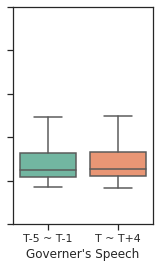

In [ ]:
import seaborn as sns


# conditional_volatility = results.conditional_volatility
# fx = sns.boxplot(x='cha_change', y=conditional_volatility, data=df, palette='Set2',showfliers=False)
# plt.ylim([0, 0.1])
# fx.set_xlabel("Policy Rate Change")
# fx.set_ylabel("Conditional Variance")

fig, fx = plt.subplots(figsize=(2.5, 4))

# df_filtered = df[df["mper_change"] != "all range"]
# fx = sns.boxplot(x='mper_change', y=conditional_volatility, data=df_filtered, palette='Set2',showfliers=False)
# plt.ylim([0, 0.1])
# fx.set_xlabel("MPR Publication")
# fx.set_ylabel("")
# fx.set(yticklabels=[])

# df_filtered = df[df["mee2_change"] != "all range"]
# fx = sns.boxplot(x='mee2_change', y=conditional_volatility, data=df_filtered, palette='Set2', showfliers=False)
# plt.ylim([0, 0.1])
# fx.set_xlabel("Minutes w/o rate change")
# fx.set_ylabel("")
# fx.set(yticklabels=[])


df_filtered = df[df["spe_change"] != "all range"]
fx = sns.boxplot(x='spe_change', y=conditional_volatility, data=df_filtered, palette='Set2', showfliers=False)
plt.ylim([0, 0.1])
fx.set_xlabel("Governer's Speech")
fx.set_ylabel("")
fx.set(yticklabels=[])


In [ ]:
# Perform tests for heteroskedasticity and autocorrelation
lb_test = acorr_lm(results.resid)     # for autocorrelation
arch_test = het_arch(results.resid)   # for heteroscedasticity


# Check for heteroskedasticity and print a warning if detected
print("ARCH-LM test statistic:", arch_test[0])
print("ARCH-LM test p-value:", arch_test[1])

if arch_test[1] < 0.05:
    print("\nWarning: Heteroskedasticity detected according to the ARCH-LM test.")

# Check for autocorrelation and print a warning if detected

print("Lagrange Multiplier test statistic:", lb_test[0])
print("Lagrange Multiplier test p-value:", lb_test[1])

if lb_test[1] < 0.05:
    print("\nWarning: Autocorrelation detected according to the Lagrange Multiplier test.")

# Check if the model is ARCH-effective using the p-value of the LM test
if lb_test[1] < 0.05:
    print("\nThe model is not ARCH-effective according to the LM test.")
else:
    print("\nThe model is ARCH-effective according to the LM test.")

In [ ]:
# Assuming your fitted GARCH model is stored in the variable 'results'
# forecast_volatility = results.forecast(horizon=1)
# conditional_volatility = np.sqrt(forecast_volatility.variance.iloc[-len(df):])


# Get the conditional volatility values
conditionalvolatility = pd.Series(results.conditional_volatility, index=df.index)
actualvolatility = np.sqrt(results.resid**2)

# Export the data to an Excel file
conditionalvolatility.to_excel('conditional_volatility.xlsx', header=['Conditional Volatility'])
actualvolatility.to_excel('acualvolatility.xlsx', header=['Actual Volatility'])

The main difference between EGARCH (Exponential GARCH) and GARCH (Generalized Autoregressive Conditional Heteroscedasticity) models is the way they model the conditional volatility of a time series.

GARCH models assume that the conditional volatility is a function of past squared error terms and past conditional variances. EGARCH models, on the other hand, allow the conditional variance to depend on both past squared error terms and past absolute error terms. This means that EGARCH models can capture the asymmetric effects of positive and negative shocks on volatility.

In other words, the EGARCH model allows for the possibility that an unexpected shock that leads to a large negative return has a different impact on volatility than an unexpected shock that leads to a large positive return. This is important in financial applications, where volatility tends to increase more after large negative returns (i.e., "leverage effect").

Overall, the EGARCH model is a more flexible model that can capture the asymmetric effects of shocks on volatility, while the GARCH model is a more simple model that assumes symmetric effects.

In [ ]:
# # Fit the EGARCH(p,q) model

# # Define the independent variables
# y = df['b_3y_l']

# # Fit the EGARCH(1,1) model
# am = arch_model(y, mean="AR", vol="EGARCH", p=1, q=1, dist='Normal')     ## Clear Trend가 있을 경우 mean = AR, 아닐 경우 Conditional mean이 Constant하다고 하는 것이 보통
# results = am.fit()

# # Print model summary
# print(results.summary())